# SMART 
The System-integrated modular advanced reactor (SMART) is an integral-type PWR with a rated power
of 365 MWt (107 MWe). Jointly developed by KAERI (ROK) and K.A.CARE (KSA), SMART is a multi-purpose reactor for electricity generation, sea water desalination, district heating, process heat for industries and also suitable for small or isolated grids [1]. The following is a OpenMC model of the SMART core.

Refer to the license statement for end-use.

## Table of contents
1. [Materials](#Materials)
2. [Geometry](#Geometry)
    1. [Surfaces](#Surfaces)
    2. [Regions](#Regions)
    3. [Cells](#Cells)
    4. [Pin Universes](#Pin)
    5. [Assembly](#Assembly)
        1. [Lattice type-definitions](#Lattice_type-definitions)
        2. [Assembly type-definitions](#Assembly_type-definitions)
    6. [Core](#Core)
3. [Settings and tallies](#Settings)
4. [Postprocessing](#Postprocessing)
5. [References](#References)


In [31]:
%matplotlib inline
import openmc
import openmc.model
import openmc.deplete
import math
import numpy as np
import matplotlib.pyplot as plt
import os

# Materials <a name="Materials"></a>

In [32]:
# 4.95w/o UO2 fuel rods
uo2=openmc.Material(name="UO2") 
uo2.set_density('g/cm3',10.286)
uo2.temperature=1200.0
uo2.add_nuclide('U238',0.83831,'wo')
uo2.add_nuclide('U235',0.04311,'wo')
uo2.add_nuclide('O16',0.11858,'wo')

# Al2O3-B4C primary burnable absorber 
al2o3_b4c=openmc.Material(name="Al2O3-B4C") 
al2o3_b4c.set_density('g/cm3',3.30233)
al2o3_b4c.temperature=900
al2o3_b4c.add_nuclide('Al27',0.3434,'wo')
al2o3_b4c.add_nuclide('O16',0.3052,'wo')
al2o3_b4c.add_element('B',0.2750,'wo')
al2o3_b4c.add_element('C',0.0764,'wo')

# al2o3=openmc.Material(material_id=98,name="Al2O3") 
# al2o3.set_density('g/cm3',3.970000)
# al2o3.temperature=293.6
# al2o3.add_nuclide('O16',0.470749,'wo')
# al2o3.add_nuclide('Al27',0.529251,'wo')

# b4c=openmc.Material(material_id=99,name="B4C") 
# b4c.set_density('g/cm3',2.520000)
# b4c.temperature=293.6
# b4c.add_element('B',0.782610,'wo')
# b4c.add_element('C',0.217390,'wo')

#
# 12w/o Gd2O3 1.8w/o UO2 Integrated Burnale Absorber 
#
# 12w/o Gd2O3 
# The enrichment is in Gd155
# Each isotope weight fraction must be calculated using the natural weight fraction as basis for normalization 
gd2o3_ba=openmc.Material(name="Gd2O3-12w/o") 
gd2o3_ba.set_density('g/cm3',7.407) # https://www.americanelements.com/gadolinium-oxide-12064-62-9
gd2o3_ba.temperature=900.0
gd2o3_ba.add_nuclide('Gd152',0.0017,'wo')
gd2o3_ba.add_nuclide('Gd154',0.0191,'wo')
gd2o3_ba.add_nuclide('Gd155',0.1025,'wo')
gd2o3_ba.add_nuclide('Gd156',0.1818,'wo')
gd2o3_ba.add_nuclide('Gd157',0.1399,'wo')
gd2o3_ba.add_nuclide('Gd158',0.2235,'wo')
gd2o3_ba.add_nuclide('Gd160',0.1991,'wo')
gd2o3_ba.add_nuclide('O16',0.1323,'wo')
# the following doesn't work in openmc because Gd has more than 2 isotopes, had to do it manually 
# gd2o3_ba.add_element('Gd',2.0,enrichment=12.0,enrichment_target='Gd155',enrichment_type='wo')
# gd2o3_ba.add_nuclide('O16',3.0,'wo')
#
# 1.8w/o UO2 
uo2_ba=openmc.Material(name="UO2-1.8w/o") 
uo2_ba.set_density('g/cm3',10.4) # % https://serpent.vtt.fi/mediawiki/index.php/Tutorial
uo2_ba.temperature=900.0
uo2_ba.add_nuclide('U238',0.86579,'wo')
uo2_ba.add_nuclide('U235',0.01567,'wo')
uo2_ba.add_nuclide('O16',0.11854,'wo')
#
# vary Gd2O3 concentration between 2w/o to 7w/o 
gd2o3_uo2 = openmc.Material.mix_materials([gd2o3_ba,uo2_ba],[0.07,0.93],'wo')

# Boron Carbide
b4c=openmc.Material(name="B4C") 
b4c.set_density('g/cm3',2.520000)
b4c.temperature=900.0
b4c.add_element('B',0.782610,'wo')
b4c.add_element('C',0.217390,'wo')

# AgInCd regulating rod 
agincd=openmc.Material(name="AgInCd") 
agincd.set_density('g/cm3',10.17)
agincd.temperature=900.0
agincd.add_nuclide('Ag107',0.41440,'wo')
agincd.add_nuclide('Ag109',0.38560,'wo')
agincd.add_nuclide('Cd106',0.00060,'wo')
agincd.add_nuclide('Cd108',0.00045,'wo')
agincd.add_nuclide('Cd110',0.00620,'wo')
agincd.add_nuclide('Cd111',0.00640,'wo')
agincd.add_nuclide('Cd112',0.01205,'wo')
agincd.add_nuclide('Cd113',0.00615,'wo')
agincd.add_nuclide('Cd114',0.01445,'wo')
agincd.add_nuclide('Cd116',0.00370,'wo')
agincd.add_nuclide('In113',0.00645,'wo')
agincd.add_nuclide('In115',0.14355,'wo')
agincd.add_nuclide('Sn114',0.00000,'wo')
agincd.add_nuclide('Sn116',0.00000,'wo')

# Steel, Stainless 304
ss=openmc.Material(name="SS304") 
ss.set_density('g/cm3',8.000000)
ss.temperature=900.0
ss.add_element('C',0.000400,'wo')
ss.add_element('Si',0.005000,'wo')
ss.add_nuclide('P31',0.000230,'wo')
ss.add_element('S',0.000150,'wo')
ss.add_element('Cr',0.190000,'wo')
ss.add_nuclide('Mn55',0.010000,'wo')
ss.add_element('Fe',0.701730,'wo')
ss.add_element('Ni',0.092500,'wo')

# Zircaloy-2
zr2=openmc.Material(name="ZR2") 
zr2.set_density('g/cm3',6.560000)
zr2.temperature=900.0
zr2.add_nuclide('O16',0.001197,'wo')
zr2.add_element('Cr',0.000997,'wo')
zr2.add_element('Fe',0.000997,'wo')
zr2.add_element('Ni',0.000499,'wo')
zr2.add_element('Zr',0.982348,'wo')
zr2.add_element('Sn',0.013962,'wo')

# Zircaloy-4
zr4=openmc.Material(name="ZR4") 
zr4.set_density('g/cm3',6.560000)
zr4.temperature=900.0
zr4.add_nuclide('O16',0.001196,'wo')
zr4.add_element('Cr',0.000997,'wo')
zr4.add_element('Fe',0.001994,'wo')
zr4.add_element('Zr',0.981858,'wo')
zr4.add_element('Sn',0.013955,'wo')

# Light Water 
h2o = openmc.Material(name="H2O")
h2o.set_density('g/cm3',1.0)
h2o.temperature=600.0
h2o.add_nuclide('H1',0.6667)
h2o.add_nuclide('O16',0.3333)
h2o.add_s_alpha_beta('c_H_in_H2O')

materials = openmc.Materials([uo2,al2o3_b4c,gd2o3_uo2,b4c,agincd,ss,zr2,zr4,h2o])
# materials.cross_sections = '/mnt/h/endfb80_hdf5/cross_sections.xml' 
materials.export_to_xml()
# !cat materials.xml

# Geometry<a name="Geometry"></a>

##  Surfaces<a name="Surfaces"></a>

In [33]:
# fuel rods and integrated burnable absorbers
fr_meat_radius=openmc.ZCylinder(x0=0.0, y0=0.0, r=0.4096)
fr_clad_inner_radius=openmc.ZCylinder(x0=0.0, y0=0.0, r=0.41875)
fr_clad_outer_radius=openmc.ZCylinder(x0=0.0, y0=0.0, r=0.4750)

# regulating control rods
rr_radius=openmc.ZCylinder(x0=0.0, y0=0.0, r=0.43305)   # rcr --> regulating control rod
rr_clad_inner_radius=openmc.ZCylinder(x0=0.0, y0=0.0, r=0.4369)
rr_clad_outer_radius=openmc.ZCylinder(x0=0.0, y0=0.0, r=0.48385)

# instrumentation tubes
it_clad_inner_radius = openmc.ZCylinder(x0=0.0, y0=0.0, r=0.5615)
it_clad_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, r=0.6120)

## Regions<a name="Regions"></a>

In [34]:
# fuel 
fr_meat_region = -fr_meat_radius
fr_gap_region = -fr_clad_inner_radius & +fr_meat_radius
fr_clad_region = -fr_clad_outer_radius & +fr_clad_inner_radius
fr_outside_region = +fr_clad_outer_radius

# regulating control rod
rr_meat_region = -rr_radius
rr_gap_region = -rr_clad_inner_radius & +rr_radius
rr_clad_region = -rr_clad_outer_radius & +rr_clad_inner_radius
rr_outside_region = +rr_clad_outer_radius

# instrumentation tube
it_gap_region = -it_clad_inner_radius
it_clad_region = -it_clad_outer_radius & +it_clad_inner_radius
it_outside_region = +it_clad_outer_radius


## Cells<a name="Cells"></a>

In [35]:
# fuel rods
fr_meat_cell = openmc.Cell(fill=uo2, region=fr_meat_region)
fr_gap_cell = openmc.Cell(fill=None, region=fr_gap_region)
fr_clad_cell = openmc.Cell(fill=zr4, region=fr_clad_region)
fr_outside_cell = openmc.Cell(fill=h2o, region=fr_outside_region)

# regulating control rods (ag-in-cd)
rr_meat_cell = openmc.Cell(fill=agincd, region=rr_meat_region)
rr_gap_cell = openmc.Cell(fill=None, region=rr_gap_region)
rr_clad_cell = openmc.Cell(fill=zr4, region=rr_clad_region)
rr_outsider_cell = openmc.Cell(fill=h2o, region=rr_outside_region)

# shutdown control rods (10% enriched b4c)
sr_meat_cell = openmc.Cell(fill=b4c, region=rr_meat_region)
sr_gap_cell = openmc.Cell(fill=None, region=rr_gap_region)
sr_clad_cell = openmc.Cell(fill=zr4, region=rr_clad_region)
sr_outside_cell = openmc.Cell(fill=h2o, region=rr_outside_region)

# integrated burnable absorber (gd2o3-uo2)
bar_meat_cell = openmc.Cell(fill=gd2o3_uo2, region=rr_meat_region) 
bar_gap_cell = openmc.Cell(fill=None, region=rr_gap_region)
bar_clad_cell = openmc.Cell(fill=zr4, region=rr_clad_region)
bar_outside_cell = openmc.Cell(fill=h2o, region=rr_outside_region)

# instrumentation tube 
it_gap_cell = openmc.Cell(fill=None, region=it_gap_region)           
it_clad_cell = openmc.Cell(fill=zr4, region=it_clad_region)
it_outside_cell = openmc.Cell(fill=h2o, region=it_outside_region)

## Pin Universes<a name="Pin"></a> 

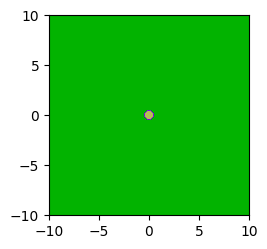

In [36]:
# fuel rod
FR = openmc.Universe(cells=[fr_meat_cell,fr_gap_cell,fr_clad_cell,fr_outside_cell])        # FR for fuel rod
FR.plot(width=(20.0, 20.0), basis='xy', color_by='material')
# FR.plot(width=(20.0, 20.0), basis='yz', color_by='material')

# regulating rod
RR = openmc.Universe(cells=[rr_meat_cell, rr_gap_cell, rr_clad_cell, rr_outsider_cell])    # RR fot regualting rod (capital e disi jeno assembly te khujte shubodha hoy)
# RR.plot(width=(20.0, 20.0), basis='xy', color_by='material')
# RR.plot(width=(20.0, 20.0), basis='yz', color_by='material')

# shutdown rod
SR = openmc.Universe(cells=[sr_meat_cell, sr_gap_cell, sr_clad_cell, sr_outside_cell])     # SR fot regualting rod (capital e disi jeno assembly te khujte shubodha hoy)
# SR.plot(width=(20.0, 20.0), basis='xy', color_by='material')
# SR.plot(width=(20.0, 20.0), basis='yz', color_by='material')

# integrated burnable absorber rod
AR = openmc.Universe(cells=[bar_meat_cell, bar_gap_cell, bar_clad_cell, bar_outside_cell]) # AR fot burnable Absorber rod (capital e disi jeno assembly te khujte shubodha hoy)
# AR.plot(width=(20.0, 20.0), basis='xy', color_by='material')
# AR.plot(width=(20.0, 20.0), basis='yz', color_by='material')

# instrumentationn tube
IT = openmc.Universe(cells=[it_gap_cell, it_clad_cell, it_outside_cell])
# IT.plot(width=(20.0, 20.0), basis='xy', color_by='material')
# IT.plot(width=(20.0, 20.0), basis='yz', color_by='material')


# Assembly<a name="Assembly"></a>

## Lattice type-definitions<a name="Lattice_type-definitions"></a> 

In [37]:
# lattice type A 
lat_a = openmc.RectLattice()
lat_a.lower_left = -10.7100, -10.7100
lat_a.pitch = (1.26, 1.26)
lat_a.universes = [
#    1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17
    [FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR], # 1
    [FR, FR, SR, FR, SR, FR, FR, SR, FR, SR, FR, FR, SR, FR, SR, FR, FR], # 2
    [FR, SR, FR, FR, FR, IT, FR, FR, IT, FR, FR, FR, IT, FR, FR, SR, FR], # 3
    [FR, FR, FR, IT, FR, FR, FR, FR, FR, FR, FR, FR, FR, IT, FR, FR, FR], # 4
    [FR, SR, FR, FR, AR, FR, FR, AR, FR, AR, FR, FR, AR, FR, FR, SR, FR], # 5
    [FR, FR, IT, FR, FR, IT, FR, FR, IT, FR, FR, IT, FR, FR, IT, FR, FR], # 6
    [FR, FR, FR, FR, FR, FR, FR, FR, SR, FR, FR, FR, FR, FR, FR, FR, FR], # 7
    [FR, SR, FR, FR, AR, FR, FR, FR, FR, FR, FR, FR, AR, FR, FR, SR, FR], # 8
    [FR, FR, IT, FR, FR, IT, SR, FR, IT, FR, SR, IT, FR, FR, IT, FR, FR], # 9  
    [FR, SR, FR, FR, AR, FR, FR, FR, FR, FR, FR, FR, AR, FR, FR, SR, FR], # 10
    [FR, FR, FR, FR, FR, FR, FR, FR, SR, FR, FR, FR, FR, FR, FR, FR, FR], # 11
    [FR, FR, IT, FR, FR, IT, FR, FR, IT, FR, FR, IT, FR, FR, IT, FR, FR], # 12
    [FR, SR, FR, FR, AR, FR, FR, AR, FR, AR, FR, FR, AR, FR, FR, SR, FR], # 13
    [FR, FR, FR, IT, FR, FR, FR, FR, FR, FR, FR, FR, FR, IT, FR, FR, FR], # 14
    [FR, SR, FR, FR, FR, IT, FR, FR, IT, FR, FR, FR, IT, FR, FR, SR, FR], # 15
    [FR, FR, SR, FR, SR, FR, FR, SR, FR, SR, FR, FR, SR, FR, SR, FR, FR], # 16
    [FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR]] # 17
lat_a_outer_cell = openmc.Cell(fill=h2o)
lat_a.outer = openmc.Universe(cells=[lat_a_outer_cell])
# padding the lattice universe w/ infinite water cell 

# lattice type B
lat_b = openmc.RectLattice()
lat_b.lower_left = -10.7100, -10.7100
lat_b.pitch = (1.26, 1.26)
lat_b.universes = [
#    1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17
    [FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR],   # 1
    [FR, FR, FR, SR, FR, FR, FR, FR, FR, FR, FR, FR, FR, SR, FR, FR, FR],   # 2
    [FR, FR, FR, FR, FR, IT, SR, FR, IT, FR, SR, IT, FR, FR, FR, FR, FR],   # 3
    [FR, SR, FR, IT, FR, FR, FR, FR, FR, FR, FR, FR, FR, IT, FR, SR, FR],   # 4
    [FR, FR, FR, FR, AR, FR, FR, FR, FR, FR, FR, FR, AR, FR, FR, FR, FR],   # 5
    [FR, FR, IT, FR, FR, IT, FR, FR, IT, FR, FR, IT, FR, FR, IT, FR, FR],   # 6
    [FR, FR, SR, FR, FR, FR, SR, FR, FR, FR, SR, FR, FR, FR, SR, FR, FR],   # 7
    [FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR],   # 8
    [FR, FR, IT, FR, FR, IT, FR, FR, IT, FR, FR, IT, FR, FR, IT, FR, FR],   # 9
    [FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR],   # 10
    [FR, FR, SR, FR, FR, FR, SR, FR, FR, FR, SR, FR, FR, FR, SR, FR, FR],   # 11
    [FR, FR, IT, FR, FR, IT, FR, FR, IT, FR, FR, IT, FR, FR, IT, FR, FR],   # 12
    [FR, FR, FR, FR, AR, FR, FR, FR, FR, FR, FR, FR, AR, FR, FR, FR, FR],   # 13
    [FR, SR, FR, IT, FR, FR, FR, FR, FR, FR, FR, FR, FR, IT, FR, SR, FR],   # 14
    [FR, FR, FR, FR, FR, IT, SR, FR, IT, FR, SR, IT, FR, FR, FR, FR, FR],   # 15
    [FR, FR, FR, SR, FR, FR, FR, FR, FR, FR, FR, FR, FR, SR, FR, FR, FR],   # 16
    [FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR]]   # 17
lat_b_outer_cell = openmc.Cell(fill=h2o)
lat_b.outer = openmc.Universe(cells=[lat_b_outer_cell])

# lattice type C 
lat_c = openmc.RectLattice()
lat_c.lower_left = -10.7100, -10.7100
lat_c.pitch = (1.26, 1.26)
lat_c.universes = [
#    1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17
    [FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR], # 1
    [FR, FR, FR, SR, FR, FR, SR, FR, FR, FR, SR, FR, FR, SR, FR, FR, FR], # 2
    [FR, FR, FR, FR, FR, IT, FR, FR, IT, FR, FR, IT, FR, FR, FR, FR, FR], # 3
    [FR, SR, FR, IT, FR, FR, FR, FR, FR, FR, FR, FR, FR, IT, FR, SR, FR], # 4
    [FR, FR, FR, FR, FR, FR, SR, FR, FR, FR, SR, FR, FR, FR, FR, FR, FR], # 5
    [FR, FR, IT, FR, FR, IT, FR, FR, IT, FR, FR, IT, FR, FR, IT, FR, FR], # 6
    [FR, SR, FR, FR, SR, FR, FR, FR, AR, FR, FR, FR, SR, FR, FR, SR, FR], # 7
    [FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR], # 8
    [FR, FR, IT, FR, FR, IT, AR, FR, IT, FR, AR, IT, FR, FR, IT, FR, FR], # 9
    [FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR], # 10
    [FR, SR, FR, FR, SR, FR, FR, FR, AR, FR, FR, FR, SR, FR, FR, SR, FR], # 11
    [FR, FR, IT, FR, FR, IT, FR, FR, IT, FR, FR, IT, FR, FR, IT, FR, FR], # 12
    [FR, FR, FR, FR, FR, FR, SR, FR, FR, FR, SR, FR, FR, FR, FR, FR, FR], # 13
    [FR, SR, FR, IT, FR, FR, FR, FR, FR, FR, FR, FR, FR, IT, FR, SR, FR], # 14
    [FR, FR, FR, FR, FR, IT, FR, FR, IT, FR, FR, IT, FR, FR, FR, FR, FR], # 15
    [FR, FR, FR, SR, FR, FR, SR, FR, FR, FR, SR, FR, FR, SR, FR, FR, FR], # 16
    [FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR, FR]] # 17
lat_c_outer_cell = openmc.Cell(fill=h2o)
lat_c.outer = openmc.Universe(cells=[lat_c_outer_cell])


## Assembly type-definitions<a name="Assembly_type-definitions"></a>

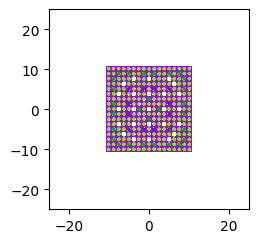

In [38]:
# surface 
fa_prism = openmc.model.rectangular_prism(21.4173,21.4173)

# region
fa_region = fa_prism

# cell
fa_a_cell=openmc.Cell(fill=lat_a, region=fa_region) # fuel assembly type A cell
fa_b_cell=openmc.Cell(fill=lat_b, region=fa_region) # fuel assembly type B cell
fa_c_cell=openmc.Cell(fill=lat_c, region=fa_region) # fuel assembly type C cell

da_cell = openmc.Cell(fill=None, region=fa_region) # dummy assembly

# universe 
FA = openmc.Universe(cells=[fa_a_cell]) # fuel assembly type A universe
FB = openmc.Universe(cells=[fa_b_cell]) # fuel assembly type B universe
FC = openmc.Universe(cells=[fa_c_cell]) # fuel assembly type C universe

XX = openmc.Universe(cells=[da_cell]) # dummy assembly universe 


# quick plots 
FA.plot(width=(50.0, 50.0), basis='xy', color_by='material')
# FB.plot(width=(50.0, 50.0), basis='xy', color_by='material')
# FC.plot(width=(50.0, 50.0), basis='xy', color_by='material')
# XX.plot(width=(50.0, 50.0), basis='xy', color_by='material')


# Core<a name="Core"></a>
<p>The core consits of 57 assemblies in a 9×9 grid.</p>

(array([ -96.37785,  -96.37785, -100.     ]),
 array([ 96.37785,  96.37785, 100.     ]))

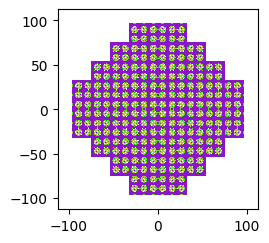

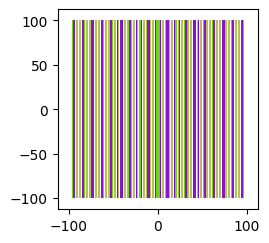

In [39]:
# lattice type core 
lat_core = openmc.RectLattice()
lat_core.lower_left = -96.3779,-96.3779
lat_core.pitch = (21.4173,21.4173)
lat_core.universes = [[XX, XX, XX, FA, FB, FA, XX, XX, XX],   #1
                      [XX, XX, FB, FB, FB, FB, FB, XX, XX],   #2
                      [XX, FB, FB, FC, FC, FC, FB, FB, XX],   #3
                      [FA, FB, FC, FC, FC, FC, FC, FB, FA],   #4
                      [FB, FB, FC, FC, FC, FC, FC, FB, FB],   #5
                      [FA, FB, FC, FC, FC, FC, FC, FB, FA],   #6
                      [XX, FB, FB, FC, FC, FC, FB, FB, XX],   #7
                      [XX, XX, FB, FB, FB, FB, FB, XX, XX],   #8
                      [XX, XX, XX, FA, FB, FA, XX, XX, XX]]   #9
lat_core_outer_cell = openmc.Cell(fill=h2o)
lat_core.outer = openmc.Universe(cells=[lat_core_outer_cell])
# 
core_prism = openmc.model.rectangular_prism(9*21.4173, 9*21.4173, boundary_type='vacuum')
core_top = openmc.ZPlane(100, boundary_type='vacuum')
core_bot = openmc.ZPlane(-100, boundary_type='vacuum')
core_region = core_prism & +core_bot & -core_top
core_cell = openmc.Cell(fill=lat_core, region=core_region)
# 
# # core universe
core = openmc.Universe(cells=[core_cell])
core.plot(width=(225, 225), basis='xy', color_by='material')
core.plot(width=(225, 225), basis='yz', color_by='material')
geometry = openmc.Geometry(root=core) 
geometry.export_to_xml()
geometry.bounding_box


# Settings and tallies <a name="Settings"></a>

In [47]:
settings = openmc.Settings()

settings.batches = 200
settings.inactive = 100
settings.particles = 100000

# settings.rel_max_lost_particles = 0.5
# settings.track = (1, 2, 4)
settings.output = {'tallies':True, 'summary':True}

entropy_mesh = openmc.RegularMesh()
entropy_mesh.lower_left, entropy_mesh.upper_right = geometry.bounding_box
entropy_mesh.dimension = (10, 10, 10)
entropy_mesh

settings.entropy_mesh = entropy_mesh
settings.export_to_xml()
# !cat settings.xml

# Tally 
energy = np.logspace(np.log10(1e-5), np.log10(20.0e6), 501)
energy_filter = openmc.EnergyFilter(energy)

tally_spectrum = openmc.Tally()
tally_spectrum.filters = [energy_filter]
tally_spectrum.scores = ['flux']

tallies=openmc.Tallies()
tallies.append(tally_spectrum)
tallies.export_to_xml()

In [41]:
# sp.close()
openmc.run(threads=8)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

       51/1    0.86948    9.08491
       52/1    0.87056    9.09096
       53/1    0.86923    9.09365
       54/1    0.86613    9.09931
       55/1    0.87283    9.10379
       56/1    0.86732    9.10424
       57/1    0.86472    9.10457
       58/1    0.86366    9.10523
       59/1    0.86370    9.10339
       60/1    0.86479    9.10654
       61/1    0.86576    9.10882
       62/1    0.86164    9.10632
       63/1    0.87006    9.10635
       64/1    0.86741    9.10490
       65/1    0.86433    9.10399
       66/1    0.86395    9.11057
       67/1    0.86493    9.11315
       68/1    0.86812    9.10868
       69/1    0.87203    9.11232
       70/1    0.86303    9.11017
       71/1    0.86533    9.10679
       72/1    0.87202    9.11070
       73/1    0.86661    9.10935
       74/1    0.86821    9.11359
       75/1    0.86887    9.12023
       76/1    0.86563    9.11820
       77/1    0.86937    9.11391
       78/1    0.87319    9.12732
       79/1    0.86497    9.12757
       80/1   

# Postprocessing<a name="Postprocessing"></a>

## Source Convergence <a name="Convergence"></a>
Load the statepoint file and plot entropy from there. Entropy should be settled by the end of inactive cycles. 

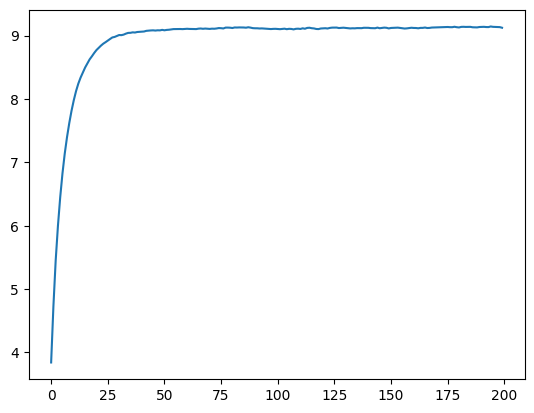

In [42]:
sp = openmc.StatePoint('statepoint.200.h5')
plt.plot(range(sp.n_batches), sp.entropy)

## Spectrum

In [43]:
t = sp.get_tally()
flux500_mean = t.mean.ravel()
flux500_unc = t.std_dev.ravel()

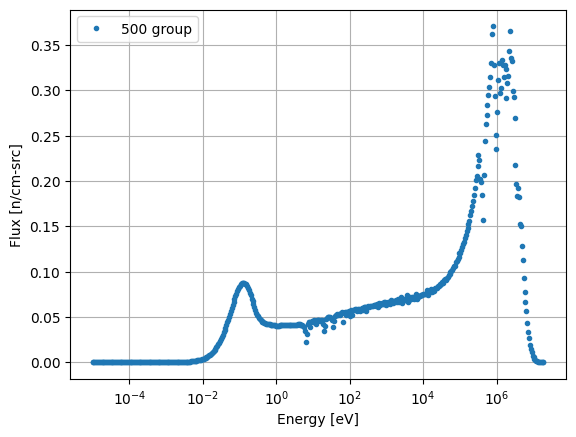

In [44]:
fig, ax = plt.subplots()
ax.step(energy[:-1], flux500_mean, '.', color='C0', label='500 group')
ax.set_xscale('log')
ax.set_xlabel('Energy [eV]')
ax.set_ylabel('Flux [n/cm-src]')
ax.grid()
ax.legend()

## Depletion<a name="Depletion"></a>

In [ ]:
# vol_calc = openmc.VolumeCalculation([core_cell], 1000000)
# vol_calc.set_trigger(1e-05, 'std_dev')
# 
# settings.volume_calculations = [vol_calc]
# openmc.calculate_volumes()
# vol_calc.load_results('volume_1.h5')
# 
# uo2.add_volume_information(volume_calc)
# ...
# 
# geometry = openmc.Geometry.from_xml()
# settings = openmc.Settings.from_xml()
# model = openmc.model.Model(geometry, settings)
# 
# chain_file = "./chain_casl_pwr.xml"
# operator = openmc.deplete.CoupledOperator(model, chain_file)
# 
# dt = [24 * 60 * 60] * 5
# power = 1e6  # constant power of 1 MW
# 
# cecm = openmc.deplete.CECMIntegrator(operator, dt, power)
# cecm.integrate()

## Plot<a name="Plot"></a>

In [46]:
# generates high-res .png file
plot_xy = openmc.Plot()
plot_xy.filename = 'smart_xy_plot'
plot_xy.basis = 'xy'
plot_xy.origin = (0.0, 0.0, 0.0)
plot_xy.width = (225., 225.)
plot_xy.pixels = (7680, 7680)
plot_xy.color_by = 'material'
plot_xy.colors = {
    uo2: (255, 255, 0), # yollow 
    agincd: (0, 255, 0), # green
    h2o: (0, 0, 255) # blue
}
plots = openmc.Plots([plot_xy])
plots.export_to_xml()
openmc.plot_geometry() # generates .png file 
openmc.plot_inline(plot_xy) # outputs inline 

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

# References <a name="References"></a>
<ol>
<li>Subki, Hadid (2020). Advances in Small Modular Reactor Technology Developments. IAEA-NPTD Webinar on Advances in Small Modular Reactor (SMR) Design and Technology Developments A Booklet Supplement to the IAEA Advanced Reactors Information System (ARIS), (p. v). International Atomic Energy Agency (IAEA).</li>
</ol>